### Retrieval-Augmented Generation (RAG) - Query Translation -  HyDe
**Problem:** User queries are challenging. If user provides an ambiguous query, they will get ambiguous matches. 
             LLMs just follow what was in the context and produce the results as it is.

**Solution:** There are multiple ways to tackle the above problem.

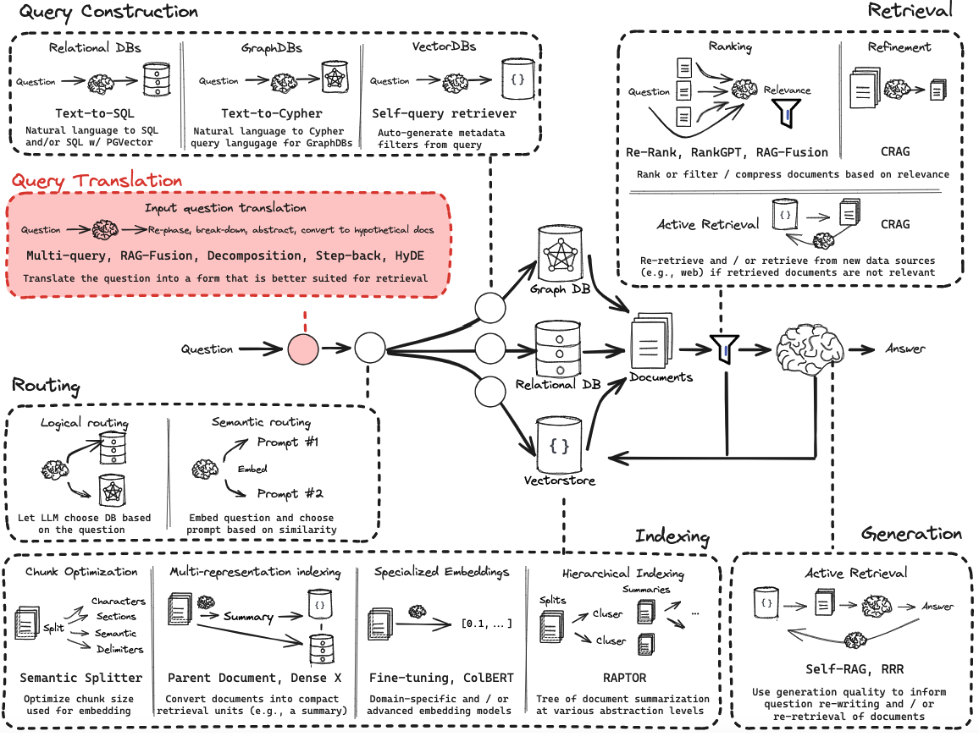
             
- More Abstraction: Refers to generalizing or **stepping back** to view the question from a higher-level perspective.
  - Example: Instead of directly asking for a specific answer, you might frame a question like, "What broader concepts should I consider for this problem?"
- Less Abstraction: Refers to breaking the question into specific, granular sub-questions that are easier to answer..
  - Example: For the question, "How does climate change affect agriculture?" sub-questions might be:
    - "What is climate change?"
    - "What are the main impacts of climate change on crop growth?"
- Rewriting the query using RAG-Fusion or Multi-Query
  - **RAG-Fusion**: Combining retrieved documents or information from multiple sources to provide a more comprehensive context.
  - **Multi-Query**: Generating multiple variations of the question to improve the chances of retrieving relevant information.
  - **Decomposition**: Breaking down a complex query into smaller sub-queries to improve the retrieval process. 

This section discusses on **Hypothetical Document Embeddings (HyDe)**, a Query Translation in RAG.

##### Key Highlights:
- **What is HyDe?**
  - HyDe stands for Hypothetical Document Embeddings, where:
    - **Hypothetical Documents**: These are generated synthetic documents (not actual documents) created based on the query.
    - The core idea is to use the hypothetical documents to narrow down the retrieval space by directing the system to documents that closely match the intended answer or context.
  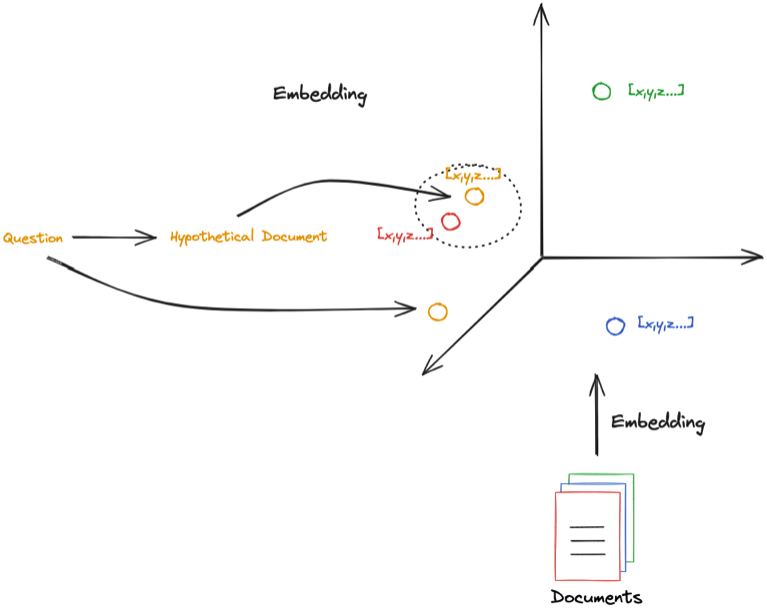
  - How HyDe works?
    - Generate a hypothetical document based on the query
    - Embed the hypothetical document
    - Retrieve real document:
      - The embedding of the hypothetical document is used as the query vector for the retrieval.
      - The retriever identifies real documents in the knowledge base that are closest to the hypothetical document embedding.
    - Generate final response.

#### Install required libraries

In [10]:
# Install required libraries
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Import required libraries

In [11]:
import os # Operating system relevant tasks
from dotenv import load_dotenv
import bs4 # Import Beautiful Soap, a Python Web Scrapping package
from langchain_community.document_loaders import WebBaseLoader # Load documents from website
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma # Import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain import hub # Python library containing pre-defined Prompts, Chains for LLM applications
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain.prompts import ChatPromptTemplate
from langchain_core.prompts import FewShotChatMessagePromptTemplate
import numpy as np
from langchain.load import dumps, loads
from operator import itemgetter

#### Environment Setup

In [12]:
# Load environment variables from .env file
load_dotenv()

# API key provides authentication to access LangChain service 
os.environ['LANGCHAIN_TRACING_V2'] = 'true' # Enables LangChain Tracing V2, a mechanism to enable and monitor the execution of LangChain applications for debugging and optimization
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com' # Configures the LangChain API End Point to use LangChain for tracing
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
# API key to access OpenAI services
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

#### RAG Process

##### Load, Split, Index

In [13]:
## Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load() 

## Split the documents based on tokens
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=50)
splits = text_splitter.split_documents(blog_docs)

## Calculate the vector embeddings of the splits, store in the vector store and convert the vector store into a retriever object
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings()) # Store the vector embeddings of splits in Chroma DB

## Retrieve the documents that are closing matching with prompt using KNN
retriever = vectorstore.as_retriever(search_kwargs={"k": 5}) 

#### **HyDe - Prompt**
Write a Prompt in such a way that a hypothetical document is generated based on the query

In [14]:
# HyDE document generation
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)


generate_docs_for_retrieval = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser() 
)

# Run
question = "What is task decomposition for LLM agents?"
generate_docs_for_retrieval.invoke({"question":question})

"Task decomposition is a fundamental concept in the field of reinforcement learning and artificial intelligence, particularly for Large Language Models (LLMs) agents. Task decomposition refers to the process of breaking down a complex task into smaller, more manageable sub-tasks or components. This allows the agent to effectively tackle the overall task by focusing on individual components sequentially or in parallel.\n\nIn the context of LLM agents, task decomposition is crucial for improving the efficiency and effectiveness of the agent's decision-making process. By breaking down a complex task into smaller sub-tasks, the agent can better understand the underlying structure of the task and identify the most relevant information needed to make informed decisions.\n\nFurthermore, task decomposition enables LLM agents to leverage their language understanding capabilities to generate more coherent and contextually relevant responses. By decomposing a task into smaller components, the age

##### Retrieve similar document based on the generated hypothetical document embedding

In [15]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever 
retrieved_docs = retrieval_chain.invoke({"question":question})
retrieved_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search

##### Invoke LLM

In [16]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

final_rag_chain.invoke({"context":retrieved_docs,"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals. This process enables efficient handling of complex tasks by transforming big tasks into multiple manageable tasks, allowing the agent to plan and execute each step effectively.'

**Few Takeaways:**

Key Applications of HyDe in RAG:
- Healthcare:
    - For complex medical queries, HyDe generates hypothetical summaries that match user intent, retrieving high-quality information.
- Research and Academia:
    - Helps researchers retrieve relevant papers or articles for broad or nuanced questions.
- Legal and Compliance:
    - Generates hypothetical interpretations of legal or regulatory queries to find matching cases or documents.

Limitations of HyDe in RAG:
- Dependence of Generative Quality:
    - If the hypothetical document is poorly generated, the retrieval process might be misdirected.
- Computational Overhead:
    - Generating and embedding hypothetical documents adds computational steps compared to direct query-based retrieval.
- Bias Risk:
    - Hypothetical documents might inadvertently introduce biases or focus on specific interpretations of the query.
